# Example: Regression with `QNNRegressor`

In this example we show how to train the `QNNRegressor` to fit a logarithm. We will also use this demonstrator to show what happens if a QNN, that was trained on a noiseless simulator is executed on a noisy simulator.

## Imports

In [23]:
import numpy as np
import matplotlib.pyplot as plt

from squlearn import Executor
from squlearn.observables import IsingHamiltonian
from squlearn.qnn import QNNRegressor, SquaredLoss
from squlearn.optimizers import SLSQP, Adam, SPSA
from src.squlearn.encoding_circuit import ChebyshevRx

We will use Qiskit's `StatevectorSimulator` for trainning.

In [24]:
executor = Executor("statevector_simulator")

## `QNNRegressor` Setup

We start by defining a parameterized quantum circuit (PQC)

In [25]:


nqubits = 4
number_of_layers = 2

pqc = ChebyshevRx(nqubits, 1, num_layers=number_of_layers)

We also need an observable

In [26]:
ising_op = IsingHamiltonian(nqubits, I="S", Z="S", ZZ="S")
print(ising_op)

SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IZII', 'ZIII', 'IIZZ', 'IZIZ', 'IZZI', 'ZIIZ', 'ZIZI', 'ZZII'],
              coeffs=[ParameterExpression(1.0*p[0]), ParameterExpression(1.0*p[1]),
 ParameterExpression(1.0*p[1]), ParameterExpression(1.0*p[1]),
 ParameterExpression(1.0*p[1]), ParameterExpression(1.0*p[2]),
 ParameterExpression(1.0*p[2]), ParameterExpression(1.0*p[2]),
 ParameterExpression(1.0*p[2]), ParameterExpression(1.0*p[2]),
 ParameterExpression(1.0*p[2])])


Now we can create the `QNNRegressor` with the PQC and cost operator. We also specify `SquaredLoss` and `SLSQP` as the loss function and optimizer respectively. Finally we specify random initial parameters for both, the PQC and cost operator.

In [27]:
np.random.seed(13)
param_ini = np.random.rand(pqc.num_parameters)
param_op_ini = np.random.rand(ising_op.num_parameters)

reg = QNNRegressor(pqc, ising_op, executor, SquaredLoss(), Adam(), param_ini, param_op_ini)

## Training

Now we are ready to train the model to fit the logarithm funciton

In [28]:
x_space = np.arange(0.1, 0.9, 0.1)
ref_values = np.log(x_space)

reg.fit(x_space, ref_values)


fit: 100%|██████████| 100/100 [25:39<00:00, 15.40s/it]

fit: 100%|██████████| 100/100 [03:35<00:00,  1.78s/it]

## Evaluation

Let's check the trained parameters of the PQC and operator

In [29]:
print("Result PQC params:", reg.param)
print("Result operator params:", reg.param_op)

Result PQC params: [ 1.23277167 -0.08635366  1.30710346  0.98232669  1.0510218   0.19436827
  0.84627712  0.45883069  0.14376988  0.83754094  0.86839313  0.31502696
 -0.87808146  0.68805119  0.6399885   0.36315213]
Result operator params: [-0.48653134  1.56935065  0.56664481]


Also let's plot the predicted function vs. the actual logarithm function

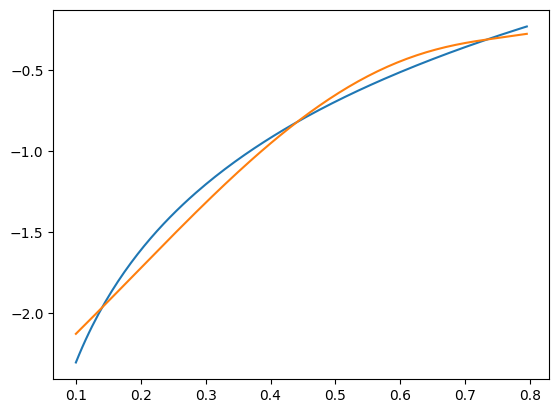

In [30]:
x = np.arange(np.min(x_space), np.max(x_space), 0.005)
y = reg.predict(x)
plt.plot(x, np.log(x))
plt.plot(x, y)

Let's also plot the error of the QNN.

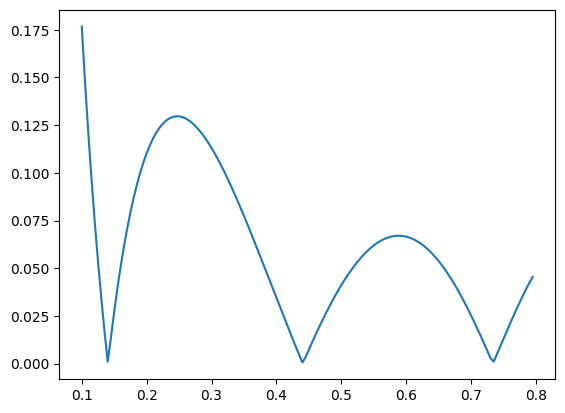

In [31]:
plt.plot(x, np.abs(y - np.log(x)))